In [91]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import os

import matplotlib.pyplot as plt
from pathlib import Path

import json

rng = np.random.default_rng(12345)
samples_per_distribution = 1000


In [92]:
top_level_output_data_path = Path(os.getcwd()) / 'simulated_data'

In [93]:
#R anges chosen to vaguely resemble plausible wealth distributions
shape_min = 0.5
shape_max = 1.5

median_min = 1
median_max = 5

# floats assumed to be in [0,1)
def shape_from_float(r):
    return shape_min + (shape_max - shape_min) * r

def median_from_float(r):
    return median_min + (median_max - median_min) * r

## 1: generate data from unconditional distributions
* Log normal (varying median + shape, aka exp(mean) and variance of underlying normal)
* Sums of two log-normals, as in a heterogenous population. These can represent either populations from misspecified distributions,
  or populations where we haven't found all the relevant covariants

### Single log-normals

In [105]:
output_data_path = top_level_output_data_path / 'unconditional_log_normal'
output_data_path.mkdir(exist_ok=True)

for i in range(10):
    
    shape = shape_from_float(rng.random())

    median = median_from_float(rng.random())

    true_parameters = {'shape': shape, 'median': median}
    with open(output_data_path / f'true_parameters_{i}', "w") as outfile: 
        json.dump(true_parameters, outfile)

    distribution = sps.lognorm(s=shape, scale=median)
    sample = distribution.rvs(size=samples_per_distribution)
    pd.DataFrame(sample).to_csv(output_data_path / f'sample_{i}.csv', index=False)

### Sums of log-normals

In [107]:
# Sums of distributions

def sample_weighted_sum_dist(dist1, dist2, weight, n_samples):
    values1 = dist1.rvs(size=n_samples)
    values2 = dist2.rvs(size=n_samples)
    choice = rng.choice([0, 1], size=n_samples, p=[weight, 1-weight]) 
    values = choice*values1 + (1-choice)*values2
    return values

output_data_path = top_level_output_data_path / 'unconditional_sum_log_normal'
output_data_path.mkdir(exist_ok=True)

for i in range(10):
    
    # Random shape between 0.5 and 1.5
    shape1 = shape_from_float(rng.random())
    shape2 = shape_from_float(rng.random())

    # Random median between 1 and 5
    median1 = shape_from_float(rng.random())
    median2 = shape_from_float(rng.random())

    # distribution will be weight*dist1 + (1-weight)*dist2
    weight = rng.random()

    true_parameters = {'shape': shape, 'median': median, 'weight': weight}
    with open(output_data_path / f'true_parameters_{i}', "w") as outfile: 
        json.dump(true_parameters, outfile)

    distribution1 = sps.lognorm(s=shape1, scale=median1)
    distribution2 = sps.lognorm(s=shape2, scale=median2)
    
    sample = sample_weighted_sum_dist(distribution1, distribution2, weight, n_samples=samples_per_distribution)
    pd.DataFrame(sample).to_csv(output_data_path / f'sample_{i}.csv', index=False)

## 2: Generate data from 1d conditional distributions

1-d covariate X will take values from 0 to 1.

### Log-normals
Here we assume shape and median both depend linearly on x, with coefficients alpha and beta, which will vary 0 to 1. Specifically
* shape = x\*alpha + 0.5, so shape varies from 0.5 to 1.5
* median = 4\*x\*beta + 1, so the median varies from 1 to 5

These exact formulas rely on the shape_min, shape_max, median_min, median_max parameters set above.

In [117]:
output_data_path = top_level_output_data_path / 'conditional_log_normal'
output_data_path.mkdir(exist_ok=True)

for i in range(50):

    alpha = rng.random()
    beta = rng.random()

    true_parameters = {'alpha': alpha, 'beta': beta}
    with open(output_data_path / f'true_parameters_{i}', "w") as outfile: 
        json.dump(true_parameters, outfile)

    sample = []
    shapes = []
    medians = []
    for _ in range(samples_per_distribution):
        
        X = rng.random()

        shape = shape_from_float(X * alpha)
        median = median_from_float(X * beta)
        
        distribution = sps.lognorm(s=shape, scale=median)
        (point,) = distribution.rvs(size=1)
        sample.append(
            {
                'X': X,
                'sample': point
            }
        )

        shapes.append(shape)
        medians.append(median)

    pd.DataFrame.from_dict(sample).to_csv(output_data_path / f'sample_{i}.csv', index=False)
    

## Playing with log normals

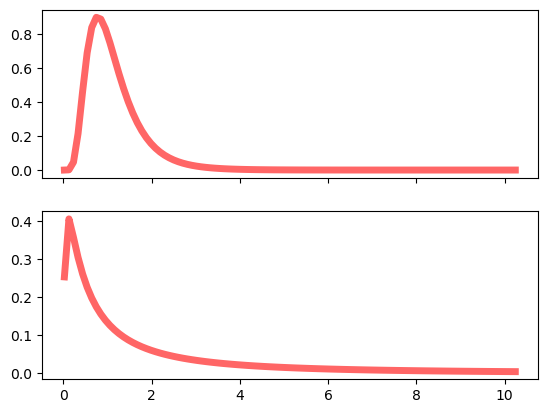

In [118]:
fig, ax = plt.subplots(2, 1, sharex=True)

x = np.linspace(
    sps.lognorm.ppf(0.0001, 1),
    sps.lognorm.ppf(0.99, 1), 
    100
)

ax[0].plot(
    x, sps.lognorm.pdf(x, s=.5, scale=1), 'r-', lw=5, alpha=0.6, label='lognorm pdf'
)
ax[1].plot(
    x, sps.lognorm.pdf(2*x, s=1.5, scale=2), 'r-', lw=5, alpha=0.6, label='lognorm pdf'
)

In [ ]:
s_array = np.linspace(